In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    if max_val - min_val == 0:
        return np.zeros(image.shape, dtype=np.uint8)
    # (image - min) / (max - min) * 255
    normalized_image = (image - min_val) / (max_val - min_val) * 255    
    normalized_image = normalized_image.astype(np.uint8)
    return normalized_image

def generate_prewitt_kernel(kSize):
    if kSize % 2 == 0:
        raise ValueError("Kernel size must be odd")
    # kernel y = kernel x transpose
    kernel_x = np.zeros((kSize, kSize), dtype=np.float32)
    kernel_x[:, 0] = -1
    kernel_x[:, -1] = 1 
    return kernel_x, kernel_x.T

def generate_sobel_kernel(kSize):
    if kSize % 2 == 0:
        raise ValueError("Kernel size must be odd")
    # kernel y = kernel x transpose
    kernel_x = np.zeros((kSize, kSize), dtype=np.float32)
    kernel_x[:,0] = -1
    kernel_x[:,-1] = 1
    for i in range(1, kSize - 1):
        kernel_x[i, 0] = -2
        kernel_x[i, -1] = 2
    kernel_y = kernel_x.T
    return kernel_x, kernel_y

def prewitt(image, kSize=3):
    kernel_x, kernel_y = generate_prewitt_kernel(kSize)
    image = image.astype(np.float32)
    pad = kSize // 2
    padded_image = np.pad(image, pad, mode = 'reflect')
    result_image = np.zeros_like(image)
    # 套用 kernel_x, kernel_y
    gradient_x = np.zeros_like(image)
    gradient_y = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            gradient_x[i, j] = np.sum(padded_image[i:i+kSize, j:j+kSize] * kernel_x)
            gradient_y[i, j] = np.sum(padded_image[i:i+kSize, j:j+kSize] * kernel_y)
    # 計算 magnitude
    result_image = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    result_image = normalize(result_image)
    return result_image

def sobel(image, kSize=3):
    kernel_x, kernel_y = generate_sobel_kernel(kSize)
    image = image.astype(np.float32)
    # kernel_x = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
    # kernel_y = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    pad = kSize // 2
    padded_image = np.pad(image, pad, mode = 'reflect')
    result_image = np.zeros_like(image)
    # 套用 kernel_x, kernel_y
    gradient_x = np.zeros_like(image)
    gradient_y = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            gradient_x[i, j] = np.sum(padded_image[i:i+kSize, j:j+kSize] * kernel_x)
            gradient_y[i, j] = np.sum(padded_image[i:i+kSize, j:j+kSize] * kernel_y)
    # 計算 magnitude
    result_image = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    result_image = normalize(result_image)
    return result_image
# Canny
def canny(image, kSize=3, weak=75, strong=255):
    kernel_x, kernel_y = generate_sobel_kernel(kSize)
    image = image.astype(np.float32)
    pad = kSize // 2
    padded_image = np.pad(image, pad, mode = 'reflect')
    result_image = np.zeros_like(image)
    gradient_x = np.zeros_like(image)
    gradient_y = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            gradient_x[i, j] = np.sum(padded_image[i:i+kSize, j:j+kSize] * kernel_x)
            gradient_y[i, j] = np.sum(padded_image[i:i+kSize, j:j+kSize] * kernel_y)
    # 上面跟 sobel 一模一樣。
    # 找出梯度的大小跟方向
    gra_mag = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    gra_dir = np.arctan2(gradient_y, gradient_x)
    supressed = np.zeros_like(gra_mag)
    # non-maxima supression, 保留邊緣點
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            angle = gra_dir[i, j]
            mag = gra_mag[i, j]
            
            # 旋轉角度, 0 ~ 180
            angle = angle * 180 / np.pi
            if angle < 0:
                angle += 180
            
            # 看看自己的鄰居, 僅保留最大的鄰居
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                neighbors = [gra_mag[i, j-1], gra_mag[i, j+1]]
            elif 22.5 <= angle < 67.5:
                neighbors = [gra_mag[i-1, j-1], gra_mag[i+1, j+1]]
            elif 67.5 <= angle < 112.5:
                neighbors = [gra_mag[i-1, j], gra_mag[i+1, j]]
            else:
                neighbors = [gra_mag[i-1, j+1], gra_mag[i+1, j-1]]
            if mag >= max(neighbors):
                supressed[i,j] = mag
    # 兩個 threshold, 來找出強強邊緣跟弱邊緣點
    # numpy 好好用!
    result_image = np.zeros_like(supressed, dtype=np.uint8)
    strong_i, strong_j = np.where(supressed >= strong);
    weak_i, weak_j = np.where((supressed >= weak) & (supressed < strong))
    result_image[strong_i, strong_j] = strong
    result_image[weak_i, weak_j] = weak
    # 邊緣追蹤
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if result_image[i, j] == weak:
                # 檢查弱邊緣周圍八個點有沒有強邊緣, 有的話就保留
                if strong in [result_image[i+ii, j+jj] for ii in [-1, 0, 1] for jj in [-1, 0, 1]]:
                    result_image[i, j] = 255
                else:
                    result_image[i, j] = 0
    return result_image


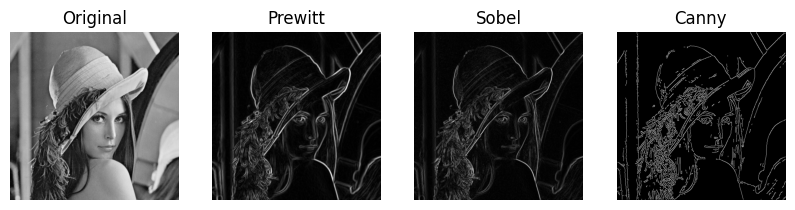

True

In [17]:
image = cv2.imread("lena.bmp", cv2.IMREAD_GRAYSCALE)
sobel_image = sobel(image, 3)
canny_image = canny(image, kSize = 5, weak = 75, strong = 225)
prewitt_image = prewitt(image, kSize = 5)

images = [image, prewitt_image, sobel_image, canny_image]
labels = ['Original','Prewitt', 'Sobel', 'Canny']
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs = axs.flatten()
for i in range(images.__len__()):
    axs[i].axis('off')
    axs[i].imshow(images[i], cmap='gray')
    axs[i].set_title(labels[i])
plt.show()

### opencv 測試

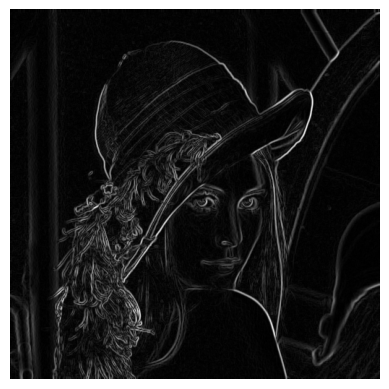

In [12]:
import cv2
import numpy as np




image = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)
prewitt_image = prewitt(image)
plt.axis('off')
plt.imshow(prewitt_image, cmap='gray')
plt.show()

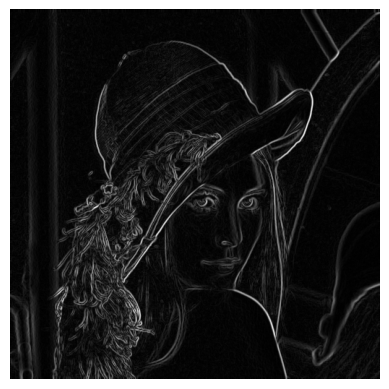

In [7]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)
# 創建 x, y 方向上的 kernel 
sobel_x = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)

cv_sobel = cv2.magnitude(sobel_x, sobel_y)

cv_sobel = cv2.normalize(cv_sobel, None, 0, 255, cv2.NORM_MINMAX)
plt.axis('off')
plt.imshow(cv_sobel, cmap='grey')
plt.show()

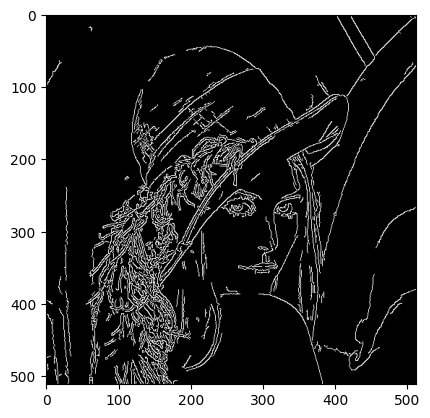

In [20]:
cv_canny_image = cv2.Canny(image, 80, 160)
plt.imshow(cv_canny_image,cmap='gray')
plt.show()